In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from dataset import prepare, assemble, transform
import regressor
import utils
import numpy as np
import pandas as pd
import cv2 as cv
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Reshape, Conv2D, Flatten
from keras.utils import multi_gpu_model
qfrom pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

Using TensorFlow backend.


In [3]:
def build_model2():
    nb_filters = 8
    model = Sequential()
    model.add(Conv2D(filters=nb_filters, kernel_size=5, activation='relu', input_shape=(128,128,1)))
    model.add(Activation('relu'))

    model.add(Conv2D(nb_filters, 5))
    model.add(Activation('relu'))

    model.add(Conv2D(nb_filters, 5))
    model.add(Activation('relu'))

    model.add(Conv2D(nb_filters, 5))
    model.add(Activation('relu'))
    model.add(Dropout(0.25))

    model.add(Conv2D(nb_filters*2, 5))
    model.add(Activation('relu'))

    model.add(Conv2D(nb_filters*2, 5))
    model.add(Activation('relu'))

    model.add(Conv2D(nb_filters*2, 5))
    model.add(Activation('relu'))

    model.add(Conv2D(nb_filters*2, 5))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    model.add(Dense(2))
    model.add(Activation('softmax'))
    model = multi_gpu_model(model, gpus=4)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [4]:
df = assemble.get_dataset_df('/data/staff/common/ML-crystals/fakeset2/fake.csv', has_meta=False)

In [5]:
count_0 = len(df[df['y'] == 0])
count_1 = len(df[df['y'] == 1])
count_0, count_1

(16726, 3274)

In [6]:
excess = df[(df['y'] == 0)].sample(n=count_0-count_1)
df = df.drop(excess.index)

In [7]:
def load_images(df):
    df = transform.row_map(df, 'img', transform.raw_img, args=(False,))
    df = transform.row_map(df, 'img', transform.normed_img)
    df = transform.aug_hflip(df)
    return df


def onehot(y):
    return np.array(list(map(lambda a: [a==0, a==1], y)))


def train(model, df, val_df):
    df = load_images(df)
    val_df = load_images(val_df)
    x, y = assemble.df_to_xy(df, dict(input_shape=(128,128,1)))
    vx, vy = assemble.df_to_xy(val_df, dict(input_shape=(128,128,1)))
    y = onehot(y)
    vy = onehot(vy)
    model.fit(x, y, validation_data=(vx,vy), epochs=4, batch_size=16)

In [8]:
md = build_model2()

ResourceExhaustedError: OOM when allocating tensor with shape[128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: dense_2/bias/Assign = Assign[T=DT_FLOAT, use_locking=true, validate_shape=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](dense_2/bias, dense_2/Const)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


Caused by op 'dense_2/bias/Assign', defined at:
  File "/sw/easybuild/software/MPI/GCC-CUDA/6.4.0-2.28-9.1.85/OpenMPI/2.1.2/Python/3.6.4/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/sw/easybuild/software/MPI/GCC-CUDA/6.4.0-2.28-9.1.85/OpenMPI/2.1.2/Python/3.6.4/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/isalin/keras_env/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/isalin/keras_env/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/isalin/keras_env/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()
  File "/home/isalin/keras_env/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/sw/easybuild/software/MPI/GCC-CUDA/6.4.0-2.28-9.1.85/OpenMPI/2.1.2/Python/3.6.4/lib/python3.6/asyncio/base_events.py", line 421, in run_forever
    self._run_once()
  File "/sw/easybuild/software/MPI/GCC-CUDA/6.4.0-2.28-9.1.85/OpenMPI/2.1.2/Python/3.6.4/lib/python3.6/asyncio/base_events.py", line 1431, in _run_once
    handle._run()
  File "/sw/easybuild/software/MPI/GCC-CUDA/6.4.0-2.28-9.1.85/OpenMPI/2.1.2/Python/3.6.4/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/home/isalin/keras_env/lib/python3.6/site-packages/tornado/ioloop.py", line 758, in _run_callback
    ret = callback()
  File "/home/isalin/keras_env/lib/python3.6/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/isalin/keras_env/lib/python3.6/site-packages/tornado/gen.py", line 1233, in inner
    self.run()
  File "/home/isalin/keras_env/lib/python3.6/site-packages/tornado/gen.py", line 1147, in run
    yielded = self.gen.send(value)
  File "/home/isalin/keras_env/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 357, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/isalin/keras_env/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/home/isalin/keras_env/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 267, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/isalin/keras_env/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/home/isalin/keras_env/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 534, in execute_request
    user_expressions, allow_stdin,
  File "/home/isalin/keras_env/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/home/isalin/keras_env/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/isalin/keras_env/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/isalin/keras_env/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2819, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/isalin/keras_env/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2845, in _run_cell
    return runner(coro)
  File "/home/isalin/keras_env/lib/python3.6/site-packages/IPython/core/async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "/home/isalin/keras_env/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3020, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/isalin/keras_env/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3185, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "/home/isalin/keras_env/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-8-5f8ea6c8e474>", line 1, in <module>
    md = build_model2()
  File "<ipython-input-3-16e79ff6549c>", line 35, in build_model2
    model.add(Dense(128))
  File "/home/isalin/keras_env/lib/python3.6/site-packages/keras/engine/sequential.py", line 181, in add
    output_tensor = layer(self.outputs[0])
  File "/home/isalin/keras_env/lib/python3.6/site-packages/keras/engine/base_layer.py", line 431, in __call__
    self.build(unpack_singleton(input_shapes))
  File "/home/isalin/keras_env/lib/python3.6/site-packages/keras/layers/core.py", line 872, in build
    constraint=self.bias_constraint)
  File "/home/isalin/keras_env/lib/python3.6/site-packages/keras/legacy/interfaces.py", line 91, in wrapper
    return func(*args, **kwargs)
  File "/home/isalin/keras_env/lib/python3.6/site-packages/keras/engine/base_layer.py", line 252, in add_weight
    constraint=constraint)
  File "/home/isalin/keras_env/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py", line 402, in variable
    v = tf.Variable(value, dtype=tf.as_dtype(dtype), name=name)
  File "/sw/easybuild/software/MPI/GCC-CUDA/6.4.0-2.28-9.1.85/OpenMPI/2.1.2/TensorFlow/1.8.0-Python-3.6.4/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 235, in __init__
    constraint=constraint)
  File "/sw/easybuild/software/MPI/GCC-CUDA/6.4.0-2.28-9.1.85/OpenMPI/2.1.2/TensorFlow/1.8.0-Python-3.6.4/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 387, in _init_from_args
    validate_shape=validate_shape).op
  File "/sw/easybuild/software/MPI/GCC-CUDA/6.4.0-2.28-9.1.85/OpenMPI/2.1.2/TensorFlow/1.8.0-Python-3.6.4/lib/python3.6/site-packages/tensorflow/python/ops/state_ops.py", line 283, in assign
    validate_shape=validate_shape)
  File "/sw/easybuild/software/MPI/GCC-CUDA/6.4.0-2.28-9.1.85/OpenMPI/2.1.2/TensorFlow/1.8.0-Python-3.6.4/lib/python3.6/site-packages/tensorflow/python/ops/gen_state_ops.py", line 60, in assign
    use_locking=use_locking, name=name)
  File "/sw/easybuild/software/MPI/GCC-CUDA/6.4.0-2.28-9.1.85/OpenMPI/2.1.2/TensorFlow/1.8.0-Python-3.6.4/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/sw/easybuild/software/MPI/GCC-CUDA/6.4.0-2.28-9.1.85/OpenMPI/2.1.2/TensorFlow/1.8.0-Python-3.6.4/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3392, in create_op
    op_def=op_def)
  File "/sw/easybuild/software/MPI/GCC-CUDA/6.4.0-2.28-9.1.85/OpenMPI/2.1.2/TensorFlow/1.8.0-Python-3.6.4/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1718, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: dense_2/bias/Assign = Assign[T=DT_FLOAT, use_locking=true, validate_shape=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](dense_2/bias, dense_2/Const)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.



In [ ]:
val = df.sample(frac=0.2)
trn = df.drop(val.index)

In [ ]:
train(md, trn, val)

In [12]:
val = load_images(val)

 14%|█▍        | 186/1310 [00:00<00:00, 1858.17it/s]

row mapping raw_img


 15%|█▌        | 198/1310 [00:00<00:00, 1977.28it/s]

row mapping normed_img


 42%|████▏     | 552/1310 [00:00<00:00, 5511.06it/s]

flip augmentation


100%|██████████| 1310/1310 [00:00<00:00, 5188.68it/s]


In [18]:
vx, vy = assemble.df_to_xy(val, dict(input_shape=(128,128,1)))
ohvy = onehot(vy)

In [19]:
pvy = md.predict(vx)

In [20]:
pvy

array([[2.8746936e-02, 9.7125310e-01],
       [3.9782527e-01, 6.0217470e-01],
       [1.3375860e-04, 9.9986625e-01],
       ...,
       [9.9061841e-01, 9.3815709e-03],
       [1.5848615e-03, 9.9841511e-01],
       [2.2449916e-02, 9.7755015e-01]], dtype=float32)

In [38]:
def looking_at_white(img):
    center = (img.shape[0]//2, img.shape[1]//2)
    return img[center[0], center[1]] > 0

False


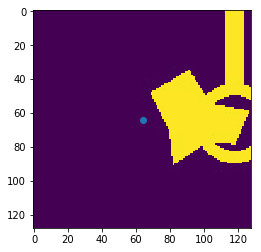

In [39]:
testim = val['img'].sample(n=1).iloc[0]
plt.imshow(testim)
plt.scatter([testim.shape[0]//2], [testim.shape[1]//2])
print(looking_at_white(testim))